# Julia is Fast - `@time`, `@elapsed` and `@inbounds`


In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](https://docs.julialang.org/en/latest/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/) on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](https://docs.julialang.org/en/latest/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.

See also [`@timev`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @time rand(10^6);
  0.001525 seconds (7 allocations: 7.630 MiB)

julia> @time begin
           sleep(0.3)
           1+1
       end
  0.301395 seconds (8 allocations: 336 bytes)
```


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.

See also [`@time`](@ref), [`@timev`](@ref), [`@timed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @elapsed sleep(0.3)
0.301391426
```


In [4]:
@time f(1) 

0.5

  0.014948 seconds (1.71 k allocations: 92.581 KiB)


In [5]:
@elapsed f(1)  # This run is much faster, since the function is already compiled

3.0e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
@time f(1_000_000) # Notice the unnaturally high byte  allocation!

2.5000025e11

  0.041402 seconds (3.00 M allocations: 45.777 MiB, 20.34% gc time)


In [7]:
@elapsed f(1_000_000) # We shall be using @time from now on

0.026087603

> Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [8]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [9]:
@time f1(1)

0.5

  0.007222 seconds (1.10 k allocations: 58.366 KiB)


In [11]:
@time f1(1_000_000)

2.5000025e11

  0.001107 seconds (5 allocations: 176 bytes)


`@time` can alo be invoked as a function:

In [12]:
@time(f1(1_000_000))

2.5000025e11

  0.001093 seconds (5 allocations: 176 bytes)


In [13]:
@time s2=f1(1_000_000)

2.5000025e11

  0.001063 seconds (6 allocations: 224 bytes)


In [14]:
@time(s2=f1(1_000_000))

2.5000025e11

  0.001279 seconds (5 allocations: 176 bytes)


## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [15]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [16]:
fexpma([1.0],0.5) # First run for compilation

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [17]:
# Big random slightly increasing sequence
A=[rand() + 0.00001*k*rand() for k=1:20_000_000]

20000000-element Array{Float64,1}:
   0.827035 
   0.14424  
   0.793661 
   0.0362188
   0.957775 
   0.191187 
   0.827674 
   0.892643 
   0.737609 
   0.70475  
   0.774801 
   0.412659 
   0.864961 
   ⋮        
  71.0017   
 188.073    
 181.037    
 114.782    
 189.05     
  75.1135   
  23.6801   
 193.31     
 110.081    
 169.553    
 134.011    
  43.8401   

In [18]:
@time X=fexpma(A,0.9)

20000000-element Array{Float64,1}:
   0.827035
   0.758756
   0.762246
   0.689644
   0.716457
   0.66393 
   0.680304
   0.701538
   0.705145
   0.705106
   0.712075
   0.682134
   0.700416
   ⋮       
  95.9069  
 105.124   
 112.715   
 112.922   
 120.535   
 115.992   
 106.761   
 115.416   
 114.883   
 120.35    
 121.716   
 113.928   

  0.200957 seconds (7 allocations: 152.588 MiB, 37.43% gc time)


## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The following program runs a little faster:

In [19]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

In [20]:
@time X=fexpma(A,0.9)

20000000-element Array{Float64,1}:
   0.827035
   0.758756
   0.762246
   0.689644
   0.716457
   0.66393 
   0.680304
   0.701538
   0.705145
   0.705106
   0.712075
   0.682134
   0.700416
   ⋮       
  95.9069  
 105.124   
 112.715   
 112.922   
 120.535   
 115.992   
 106.761   
 115.416   
 114.883   
 120.35    
 121.716   
 113.928   

  0.157801 seconds (2.06 k allocations: 152.696 MiB, 39.79% gc time)


Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is several times faster, but still slow. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In `Julia` we can use `@manipulate` command to slide through the data. It takes a while to read packages `Winston` (for plotting) and `Interact`, but this is needed only for the first invocation.

In [22]:
using Gadfly

In [29]:
using Interact

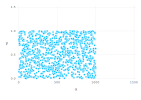

In [24]:
k=1
plot(x=collect(k:k+1000),y=A[k:k+1000])

In [30]:
@manipulate for k=1:1000:20000000
    plot(layer(x=collect(k:k+1000),y=A[k:k+1000],Geom.point),
        layer(x=collect(k:k+1000),y=X[k:k+1000],Geom.line,Theme(default_color=colorant"red")))
end

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_26", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-f01c7fe2-6f1d-448a-9bf0-0a991e18d91f", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["k"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 19999001),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1000),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_25", 9999001, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/home/jrun/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/home/jrun/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/home/jrun/.julia/v0.6/InteractBase/src/../assets/all.js", "/home/jrun/.julia/v0.6/InteractBase/src/../assets/style.css", "/home/jrun/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":9999001}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {return

### Remark
More details about optimizing your programs are given in the [Profiling Notebook](http://localhost:8890/notebooks/Documents/Julia/Julia-Course/src/05%20Profiling.ipynb).

## Pre-allocating output

The following example is from [Pre-allocating outputs](https://docs.julialang.org/en/stable/manual/performance-tips/#Pre-allocating-outputs-1). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 15 times faster: 

In [31]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!{T}(ret::AbstractVector{T}, x::T)
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array{Int}(3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [34]:
@time loopinc()

50000015000000

  0.725623 seconds (40.00 M allocations: 1.490 GiB, 24.17% gc time)


In [35]:
@time loopinc_prealloc() # After the second run

50000015000000

  0.025549 seconds (6 allocations: 288 bytes)


## Memory access

The following example is from [Access arrays in memory order, along columns](https://docs.julialang.org/en/stable/manual/performance-tips/#Access-arrays-in-memory-order,-along-columns-1).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [36]:
B = rand(0:9,4,3)

4×3 Array{Int64,2}:
 6  4  1
 6  3  2
 5  3  9
 5  1  0

In [37]:
B[:]

12-element Array{Int64,1}:
 6
 6
 5
 5
 4
 3
 3
 1
 1
 2
 9
 0

In [38]:
vec(B)

12-element Array{Int64,1}:
 6
 6
 5
 5
 4
 3
 3
 1
 1
 2
 9
 0

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [39]:
function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array{eltype(x)}(n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array{eltype(x)}(n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [40]:
copy_cols([1.0,2])
copy_rows([1.0,2])

2×2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [41]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.563021  
 0.964001  
 0.293313  
 0.578306  
 0.690826  
 0.315698  
 0.574148  
 0.874235  
 0.752203  
 0.216608  
 0.818295  
 0.684065  
 0.533485  
 ⋮         
 0.199046  
 0.211306  
 0.0737054 
 0.852768  
 0.175363  
 0.609789  
 0.619272  
 0.471764  
 0.00614664
 0.825827  
 0.278011  
 0.898733  

In [42]:
@time C=copy_cols(x)  # We generate a large matrix

5000×5000 Array{Float64,2}:
 0.563021    0.563021    0.563021    …  0.563021    0.563021    0.563021  
 0.964001    0.964001    0.964001       0.964001    0.964001    0.964001  
 0.293313    0.293313    0.293313       0.293313    0.293313    0.293313  
 0.578306    0.578306    0.578306       0.578306    0.578306    0.578306  
 0.690826    0.690826    0.690826       0.690826    0.690826    0.690826  
 0.315698    0.315698    0.315698    …  0.315698    0.315698    0.315698  
 0.574148    0.574148    0.574148       0.574148    0.574148    0.574148  
 0.874235    0.874235    0.874235       0.874235    0.874235    0.874235  
 0.752203    0.752203    0.752203       0.752203    0.752203    0.752203  
 0.216608    0.216608    0.216608       0.216608    0.216608    0.216608  
 0.818295    0.818295    0.818295    …  0.818295    0.818295    0.818295  
 0.684065    0.684065    0.684065       0.684065    0.684065    0.684065  
 0.533485    0.533485    0.533485       0.533485    0.533485    0.533485

  0.073985 seconds (9.50 k allocations: 190.880 MiB, 16.54% gc time)


In [43]:
@time D=copy_rows(x) # This is few times slower

5000×5000 Array{Float64,2}:
 0.563021  0.964001  0.293313  0.578306  …  0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306  …  0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306  …  0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 0.563021  0.964001  0.293313  0.578306     0.825827  0.278011  0.898733
 ⋮                     

  0.227159 seconds (9.50 k allocations: 190.880 MiB, 14.49% gc time)


### Remark
There is also a built-in function `repmat()`:

In [44]:
?repmat

search: 

```
repmat(A, m::Integer, n::Integer=1)
```

Construct a matrix by repeating the given matrix (or vector) `m` times in dimension 1 and `n` times in dimension 2.

# Examples

```jldoctest
julia> repmat([1, 2, 3], 2)
6-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3

julia> repmat([1, 2, 3], 2, 3)
6×3 Array{Int64,2}:
 1  1  1
 2  2  2
 3  3  3
 1  1  1
 2  2  2
 3  3  3
```


repmat



In [46]:
@time C1=repmat(x,1,5000)

5000×5000 Array{Float64,2}:
 0.563021    0.563021    0.563021    …  0.563021    0.563021    0.563021  
 0.964001    0.964001    0.964001       0.964001    0.964001    0.964001  
 0.293313    0.293313    0.293313       0.293313    0.293313    0.293313  
 0.578306    0.578306    0.578306       0.578306    0.578306    0.578306  
 0.690826    0.690826    0.690826       0.690826    0.690826    0.690826  
 0.315698    0.315698    0.315698    …  0.315698    0.315698    0.315698  
 0.574148    0.574148    0.574148       0.574148    0.574148    0.574148  
 0.874235    0.874235    0.874235       0.874235    0.874235    0.874235  
 0.752203    0.752203    0.752203       0.752203    0.752203    0.752203  
 0.216608    0.216608    0.216608       0.216608    0.216608    0.216608  
 0.818295    0.818295    0.818295    …  0.818295    0.818295    0.818295  
 0.684065    0.684065    0.684065       0.684065    0.684065    0.684065  
 0.533485    0.533485    0.533485       0.533485    0.533485    0.533485

  0.068636 seconds (10.01 k allocations: 191.040 MiB, 9.19% gc time)
